<a href="https://colab.research.google.com/github/CIS-522/course-content/blob/main/tutorials/W05_Regularization/instructor/W5_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 522 Week 5: Regularization


__Instructor:__ Lyle Ungar

__Content creators:__ Ravi Teja Konkimalla, Mohitrajhu Lingan Kumaraian

**Content reviewers:** Kavish Shah, Ann-Katrin Reuel

In [ ]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = '' #@param {type:"string"}
my_pod = 'Select' #@param ['Select', 'upain', 'ah-damn-optimizer', 'backpropagandists', 'backpropers','excel-erators','GAN-gsters','han-not-solo','hufflefluffs','lets-taco-bout-it','natural-networkers','pytorture','sigmoids','strong-signals','the-denominators','the-travellers', 'the-weekenders', 'tomorrows-incredibles', 'brute-force']
my_email = '' #@param {type:"string"}


# start timing
import time
try:t0;
except NameError: t0 = time.time()

#### Ensure you're running a GPU notebook.

From "Runtime" in the drop-down menu above, click "Change runtime type". Ensure that "Hardware Accelerator" says "GPU".

In [ ]:
#@title Import functions
from __future__ import print_function
import torch
import pathlib
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.utils.prune as prune
from torch.optim.lr_scheduler import StepLR
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import copy
from tqdm import tqdm
from IPython.display import HTML, display

#Intro: Regularization Overview
To be watched **before** the pod meets.

Video available at https://youtube.com/watch?v=bc1nsP4htVg


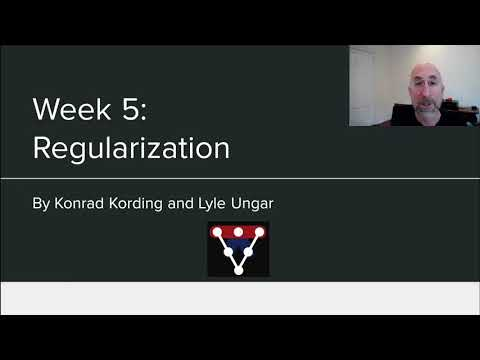

In [ ]:
#@title Video : Introduction to Regularization
try: t1;
except NameError: t1=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="bc1nsP4htVg", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

---
# Learning Objectives

We show how


1.   Big ANNs are efficient universal approximators due to adaptive basis functions
2.   ANN’s memorize some but generalize well
3.   Regularization as shrinkage of overparameterized models: L1, L2, early stopping
4.   Regularization by Dropout
5. Regularization by Data Augmentation
6. Perils of Hyper-Parameter Tuning
7.   Rethinking generalization   

# Setup
Note that some of the code for today can take up to an hour to run. We have therefore "hidden" that code and shown the resulting outputs.


In [ ]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline 
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'
SMALL_SIZE = 12

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('animation', html='jshtml')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

In [ ]:
# @title Loading Animal Faces data
%%capture
!rm -r AnimalFaces32x32/
!git clone https://github.com/arashash/AnimalFaces32x32
!rm -r afhq/
!unzip ./AnimalFaces32x32/afhq_32x32.zip

In [ ]:
# @title Loading Animal Faces Randomized data
%%capture
!rm -r Animal_faces_random/
!git clone https://github.com/Ravi3191/Animal_faces_random.git
!rm -r afhq_random_32x32/
!unzip ./Animal_faces_random/afhq_random_32x32.zip
!rm -r afhq_10_32x32/
!unzip ./Animal_faces_random/afhq_10_32x32.zip

In [ ]:
#@title Seeding for Reproducibility
seed = 90108
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_deterministic = True
def seed_worker(worker_id):
    worker_seed = seed % (worker_id+1)
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [ ]:
# @title Helper functions
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis(False)
    plt.show()

Now, lets define an Animal Net model, train, test and main functions which we will use quite frequently this week.

In [ ]:
##Network Class - Animal Faces
class Animal_Net(nn.Module):
    def __init__(self):
        torch.manual_seed(104)
        super(Animal_Net, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

The train function takes in the current model along with the train_loader and loss function and updates the parameters for a single pass to the entire dataset. The test function takes in the current model after every epoch and calculates the accuracy on the test dataset.


In [ ]:
def train(args, model, device, train_loader, optimizer, epoch,reg_function1=None,reg_function2=None,criterion=F.nll_loss):
    """
    Trains the current inpur model using the data 
    from Train_loader and Updates parameters for a single pass
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if reg_function1 is None:
            loss = criterion(output, target)
        elif reg_function2 is None:
            loss = criterion(output, target)+args['lambda']*reg_function1(model)
        else:
            loss = criterion(output, target)+args['lambda1']*reg_function1(model)+args['lambda2']*reg_function2(model)
        loss.backward()
        optimizer.step()
        

def test(model, device, test_loader, loader = 'Test',criterion=F.nll_loss):
    """
    Tests the current Model
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    return 100. * correct / len(test_loader.dataset)

def main(args, model,train_loader,val_loader,test_data,reg_function1=None,reg_function2=None,criterion=F.nll_loss):
    """
    Trains the model with train_loader and tests the learned model using val_loader
    """

    use_cuda = not args['no_cuda'] and torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu') 

    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

    val_acc_list, train_acc_list,param_norm_list = [], [], []
    for epoch in tqdm(range(args['epochs'])):
        train(args, model, device, train_loader, optimizer, epoch,reg_function1=reg_function1,reg_function2=reg_function2)
        train_acc = test(model,device,train_loader, 'Train')
        val_acc = test(model,device,val_loader, 'Val')
        param_norm = calculate_frobenius_norm(model)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        param_norm_list.append(param_norm)

    return val_acc_list, train_acc_list, param_norm_list, model, 0

#Section 1: Regularization is Shrinkage

Video available at https://youtube.com/watch?v=B4CsCKViB3k


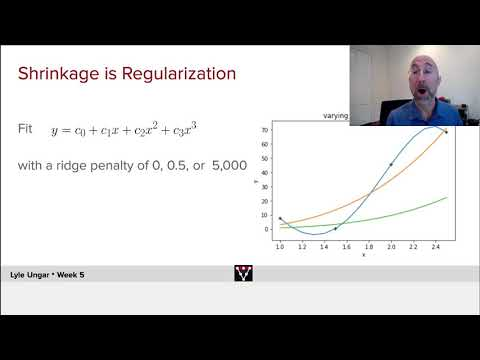

In [ ]:
#@title Video : Introduction to Regularization
try: t2;
except NameError: t2=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="B4CsCKViB3k", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

One way to think about Regularization is to think in terms of the magnitude of the overall weights of the model. A model with big weights can fit more data perfectly. Wheras a model with smaller weights tend to underperform on the train set but can suprisingly do very well on the test set. Too small of a weights can also be as issue as it can the underfit the model.

This week we use the sum of Frobenius Norm of all the tensors in the model as a metric to measure to measure the "size of the model".

##Exercise 1: Frobenius Norm
Before we start let us do a quick recollection of Frobenius Norm. The Frobenius norm, sometimes also called the Euclidean norm (a term unfortunately also used for the vector $L^2$ norm), is matrix norm of an m×n matrix A defined as the square root of the sum of the absolute squares of its elements.
\begin{equation}
||A||_F= \sqrt(\sum_{i=1}^m\sum_{j=1}^n|a_{ij}|^2)
\end{equation} 

In [ ]:
def calculate_frobenius_norm(model):

    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the grad visualization function")
    ####################################################################

    ... #TODO: Define loop to calculate the Frobenius norm

##uncomment to run
# net = nn.Linear(10,1)
# print(f'Frobenius Norm of Single Linear Layer: {calculate_frobenius_norm(net)}')

In [ ]:
## to_remove

def calculate_frobenius_norm(model):
    """
        Input: Pytorch newtork
        Output: Frobenious Norm of all the tensors of the model
    """
    norm = 0.0

    for name,param in model.named_parameters():
        norm += torch.norm(param).data         
    return norm

net = nn.Linear(10,1)
print(f'Frobenius Norm of Single Linear Layer: {calculate_frobenius_norm(net)}')

Frobenius Norm of Single Linear Layer: 0.4565333127975464


#Section 2: Overfitting

Video available at https://youtube.com/watch?v=RlaGyRKP2nY


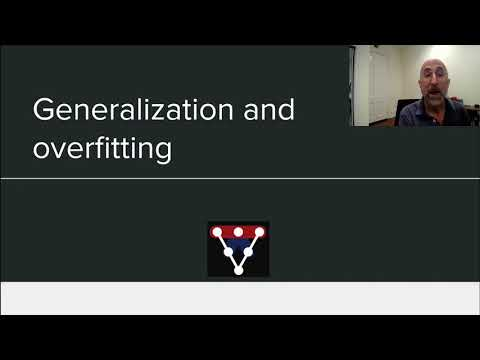

In [ ]:
#@title Video : Overfitting
try: t3;
except NameError: t3=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="RlaGyRKP2nY", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

##Visualizing Overfitting



Let's create some synthetic dataset that we will use to illustrate overfitting in neural networks.

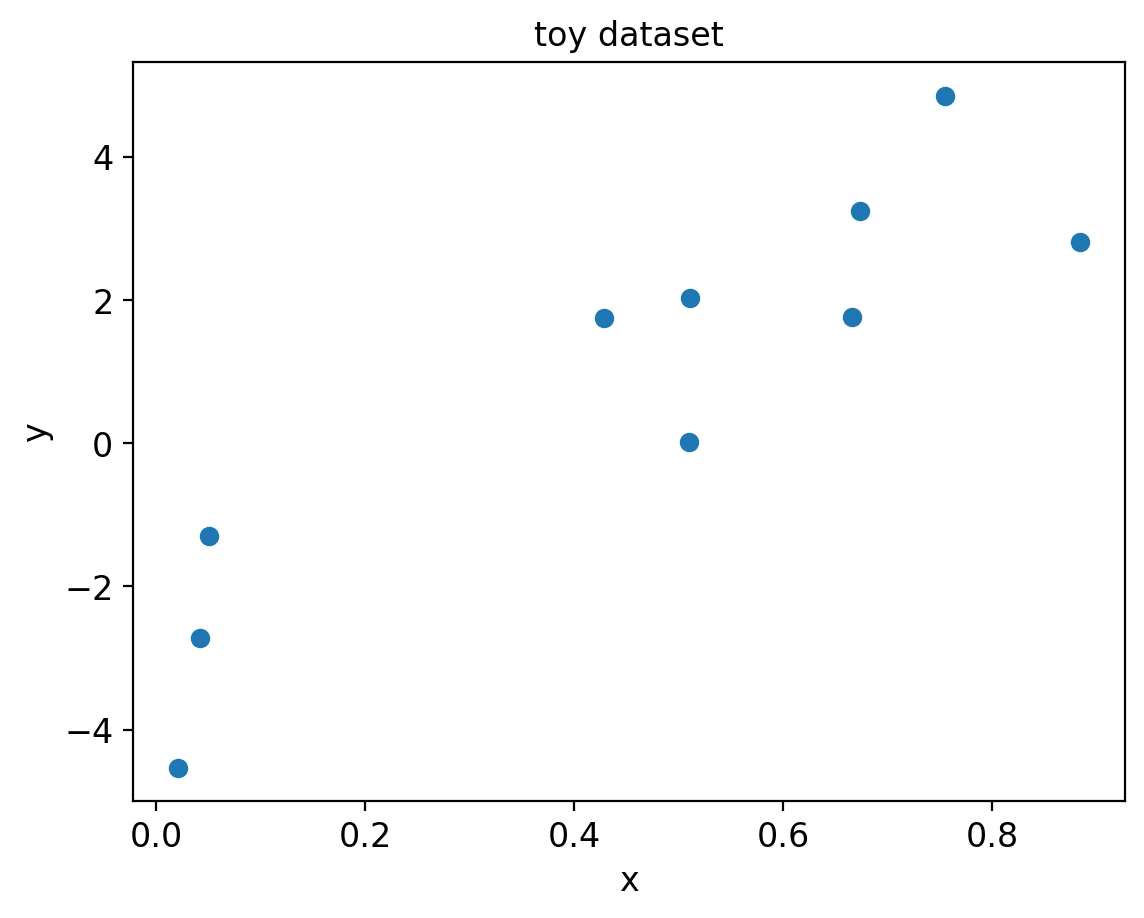

In [ ]:
#creating train data
X = torch.rand((10,1))
X.sort(dim = 0)
Y = 2*X + 2*torch.empty((X.shape[0],1)).normal_(mean=0,std=1) #adding small error in the data

X = X.unsqueeze_(1)
Y = Y.unsqueeze_(1)

#visualizing trian data
plt.scatter(X.numpy(),Y.numpy())
plt.xlabel('x')
plt.ylabel('y')
plt.title('toy dataset')
plt.show()

#creating test dataset
X_test = torch.linspace(0,1,40)
X_test = X_test.reshape((40,1,1))

Let's create a NN that can fit on the dataset we just created and train it.

In [ ]:
##Network Class - 2D
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(1, 300)
        self.fc2 = nn.Linear(300, 500)
        self.fc3 = nn.Linear(500, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        output = self.fc3(x)
        return output

In [ ]:
#train the network on toy dataset
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr = 1e-4)
max_epochs = 10000
iters = 0

running_predictions = np.empty((40,(int)(max_epochs/500 + 1)))

train_loss = []
test_loss = []
model_norm = []

for epoch in tqdm(range(max_epochs)):

    #training
    model_norm.append(calculate_frobenius_norm(model))
    model.train()
    optimizer.zero_grad()
    predictions = model(X)
    loss = criterion(predictions,Y)
    loss.backward()
    optimizer.step()

    train_loss.append(loss.data)
    model.eval()
    Y_test = model(X_test)
    loss = criterion(Y_test,2*X_test)
    test_loss.append(loss.data)

    if(epoch % 500 == 0 or epoch == max_epochs - 1):
        running_predictions[:,iters] = Y_test[:,0,0].detach().numpy()
        iters += 1

100%|██████████| 10000/10000 [00:35<00:00, 285.57it/s]


Now that we have finished training, let's see how the model has evolved over the training process.

In [ ]:
fig = plt.figure()
ax = plt.axes()
def frame(i):
    ax.clear()
    ax.scatter(X[:,0,:].numpy(),Y[:,0,:].numpy())
    plot = ax.plot(X_test[:,0,:].detach().numpy(),running_predictions[:,i])
    title = "Epoch: " + str(i * 500)
    plt.title(title)
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    return plot
anim = animation.FuncAnimation(fig, frame, frames=range(20), blit=False, repeat=False, repeat_delay=10000)
anim

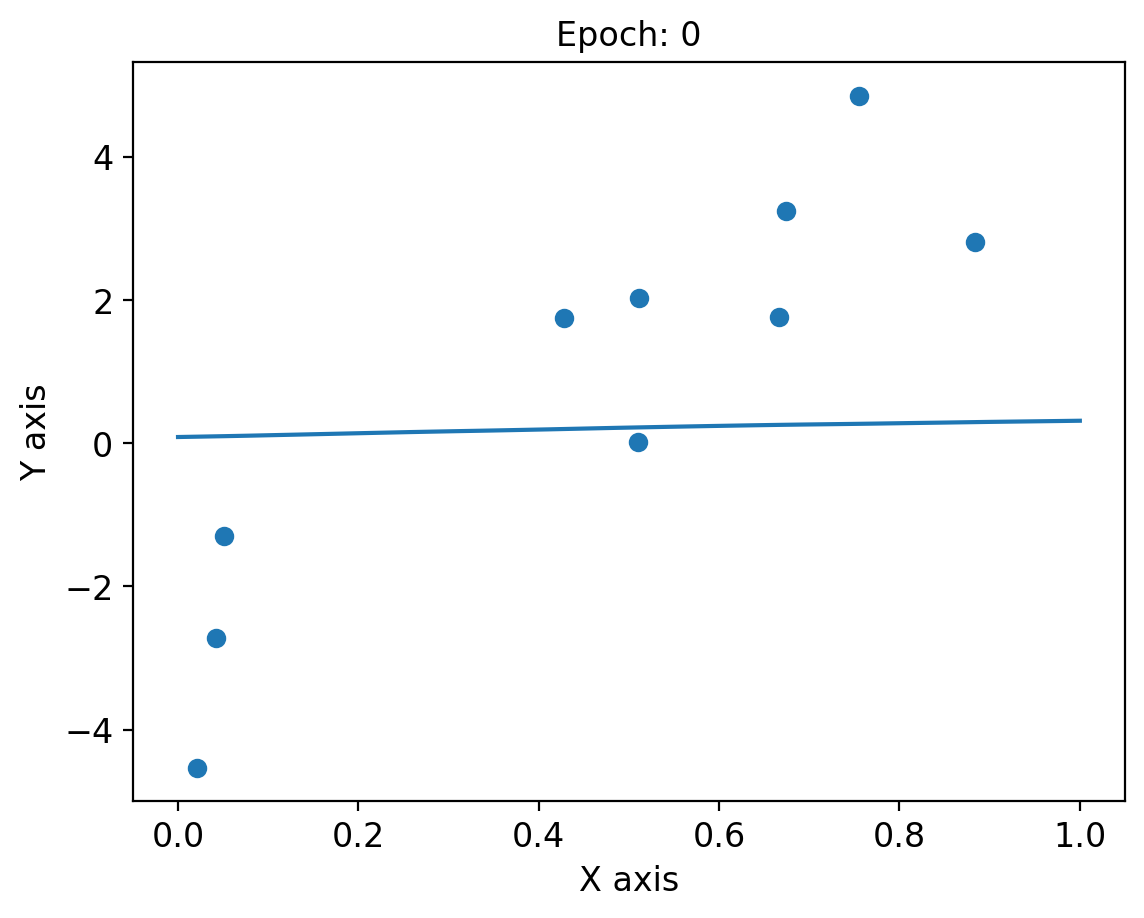

In [ ]:
#@title Plot the train and test losses [Note: You may have to run this twice]
plt.plot(train_loss,label='train_loss')
plt.plot(test_loss,label='test_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('loss vs epoch')
plt.legend()
plt.show()

Now let's vizualize the frobenious norm of the model as we trained and you should see that the value of weights increased lineraly w.r.t epochs

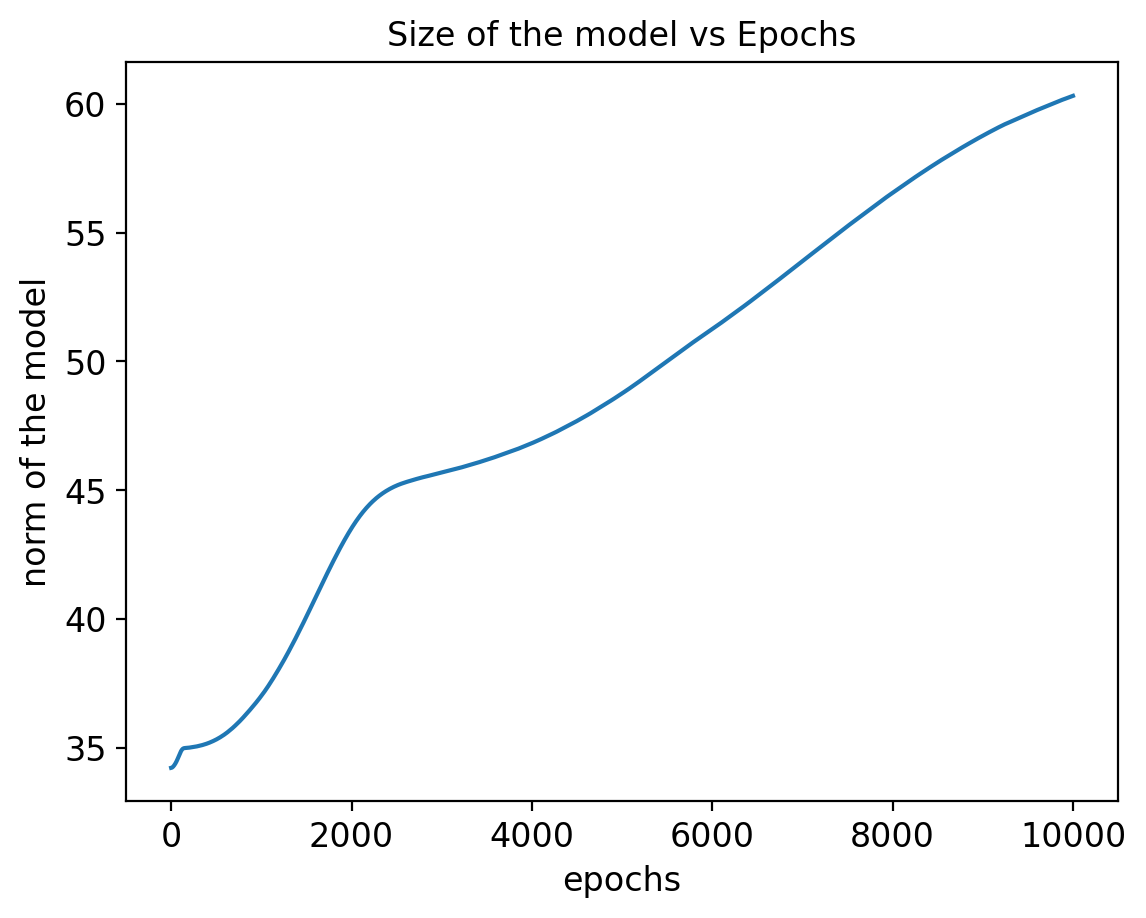

In [ ]:
#@title Frobenious norm of the model 
plt.plot(model_norm)
plt.ylabel('norm of the model')
plt.xlabel('epochs')
plt.title('Size of the model vs Epochs')
plt.show()

**Quiz Question 1:** What trend do you see w.r.t to train and test losses(where do you see the minimum of the losses)? What does it tell about the model we trained?

In [ ]:

trend = '' #@param {type:"string"}

## Overfitting on Test Dataset


In principle, we should not touch our test set until after we have chosen all our hyperparameters. Where we were to use the test data in the model selection process, there is a risk that we might overfit the test data. Then we would be in serious trouble. If we overfit our training data, there is always the evaluation on test data to keep us honest. But if we overfit the test data, how would we ever know?

Note that there is another kind of overfitting: you do "honest" fitting on one set of images or posts, or medical records, but it may not generalize to other sets of images, posts or medical records.


##Validation Dataset
A common practice to address this problem is to split our data three ways, using a validation dataset (or validation set) to tune the hyperparameters.

Ideally we would only touch the test data once, to assess the very best model or to compare a small number of models to each other, real-world test data is seldom discarded after just one use.



# Section 3: Memorization

Given sufficiently large networks and enough training, Neural Networks can acheive almost 100% train accuracy.

In this section we train three MLP's on each of the following:


1.   Animal Faces Dataset
2.   Completely Noisy Dataset (Random Shuffling of all labels)
3.   Partially Noisy Dataset (Random Shuffling of 15% labels)

Let's first create the required dataloaders for all  three datasets. Take a quick look at how we split the data.

In [ ]:
##Dataloaders for the Dataset
batch_size = 128
classes = ('cat', 'dog', 'wild')

train_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    
     ])
data_path = pathlib.Path('.')/'afhq' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)

#Splitting dataset
img_train_data, img_val_data,_ = torch.utils.data.random_split(img_dataset, [100,100,14430])

#Creating train_loader and Val_loader
train_loader = torch.utils.data.DataLoader(img_train_data,batch_size=batch_size,worker_init_fn=seed_worker)
val_loader = torch.utils.data.DataLoader(img_val_data,batch_size=1000,worker_init_fn=seed_worker)

#creating test dataset
test_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
     ])
img_test_dataset = ImageFolder(data_path/'val', transform=test_transform)

##Dataloaders for the  Random Dataset

#splitting randomized data into training and validation data 
data_path = pathlib.Path('.')/'afhq_random_32x32/afhq_random' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)
random_img_train_data, random_img_val_data,_ = torch.utils.data.random_split(img_dataset, [100,100,14430])

#Randomized train and validation dataloader
rand_train_loader = torch.utils.data.DataLoader(random_img_train_data,batch_size=batch_size,num_workers = 0, worker_init_fn=seed_worker)
rand_val_loader = torch.utils.data.DataLoader(random_img_val_data,batch_size=1000,num_workers = 0,worker_init_fn=seed_worker)

##Dataloaders for the Partially Random Dataset

#Splitting data between training and validation dataset for partially randomized data
data_path = pathlib.Path('.')/'afhq_10_32x32/afhq_10' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)
partially_random_train_data, partially_random_val_data,_ = torch.utils.data.random_split(img_dataset, [100,100,14430])

#Training and Validation loader for partially randomized data
partial_rand_train_loader = torch.utils.data.DataLoader(partially_random_train_data,batch_size=batch_size,num_workers = 0,worker_init_fn=seed_worker)
partial_rand_val_loader = torch.utils.data.DataLoader(partially_random_val_data,batch_size=1000,num_workers = 0,worker_init_fn=seed_worker)

Now let's define a model which has a very high number of parameters compared to the training data points

In [ ]:
##Network Class - Animal Faces
class Big_Animal_Net(nn.Module):
    def __init__(self):
        torch.manual_seed(104)
        super(Big_Animal_Net, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 124)
        self.fc2 = nn.Linear(124, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

100%|██████████| 200/200 [00:31<00:00,  6.31it/s]


Time to memorize the dataset: 40.84925389289856


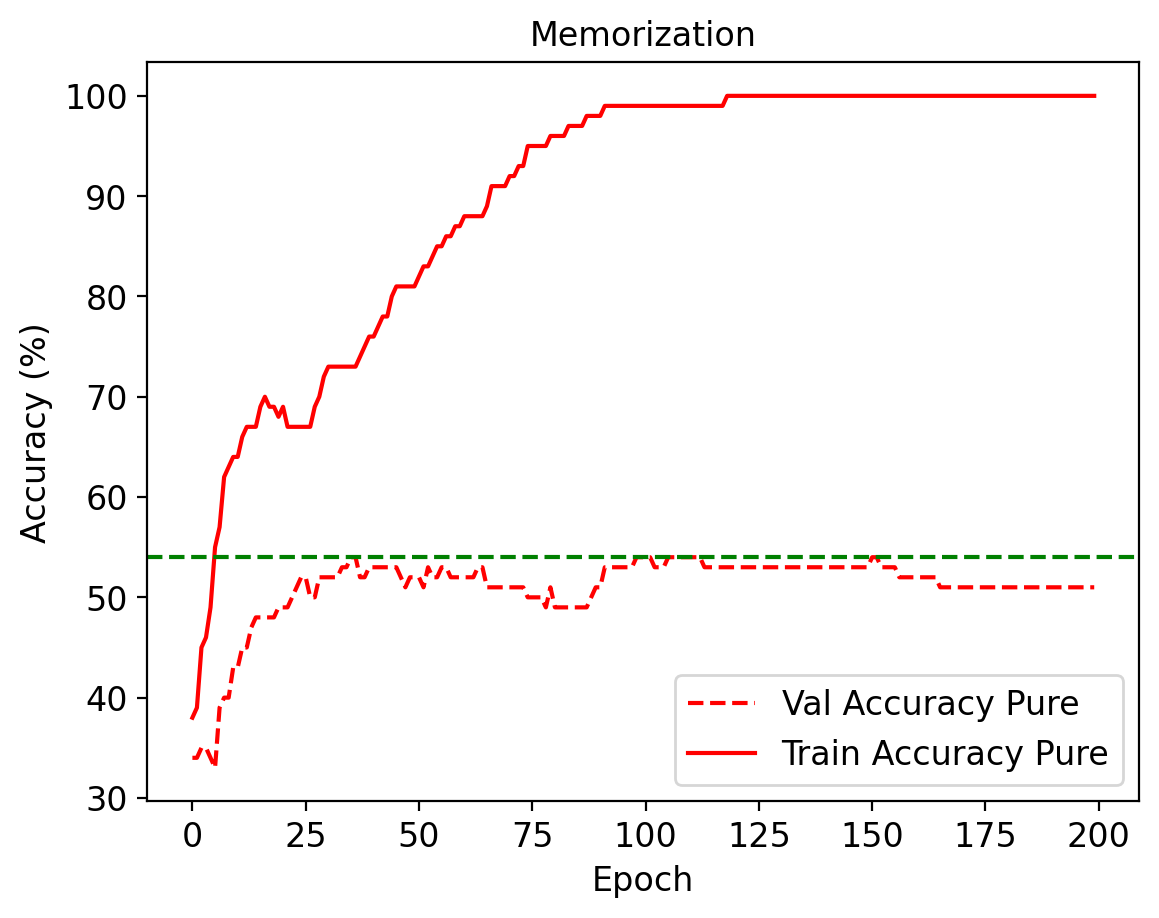

In [ ]:
##Here we have 100 true train data.
args = {'test_batch_size': 1000,
        'epochs': 200,
        'lr': 5e-3,
        'momentum': 0.9,
        'no_cuda': False,
        }

acc_dict = {}
model = Big_Animal_Net()

start_time = time.time()
val_acc_pure, train_acc_pure, _, model ,_ = main(args,model,train_loader,val_loader,img_test_dataset)
end_time = time.time()

print("Time to memorize the dataset:",end_time - start_time)

##Train and Test accuracy plot

plt.plot(val_acc_pure,label='Val Accuracy Pure',c='red',ls = 'dashed')
plt.plot(train_acc_pure,label='Train Accuracy Pure',c='red',ls = 'solid')
plt.axhline(y=max(val_acc_pure),c = 'green',ls = 'dashed')
plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

##Data Visualizer
Before we proceed to train the model on data with random labels, let us visualize and verify for ourselves if the data is random.

The image belongs to : dog


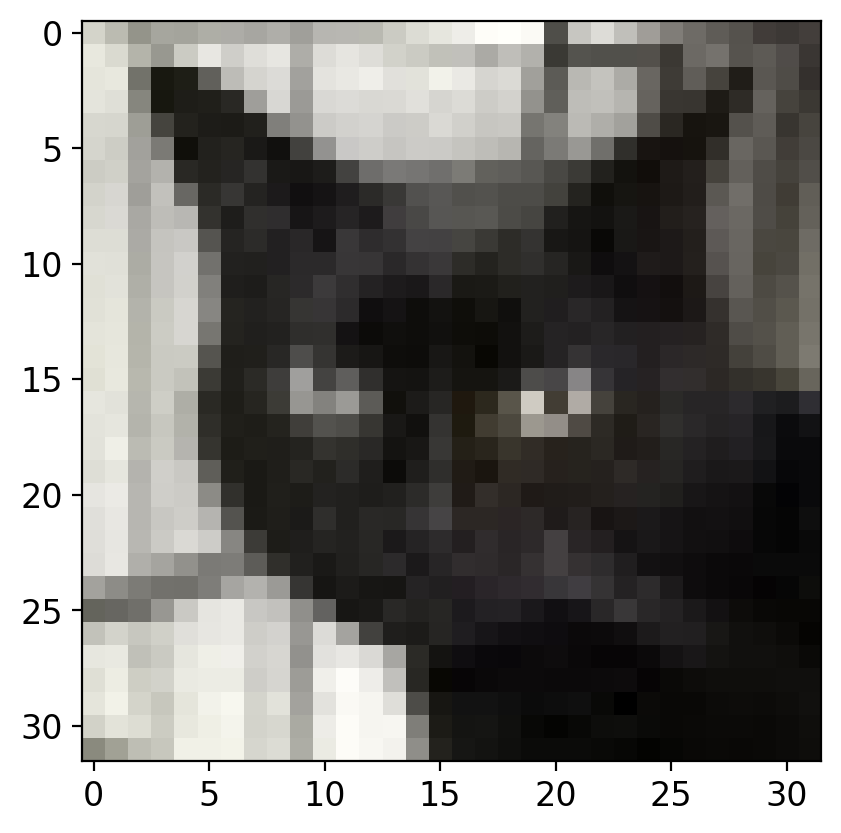

In [ ]:
def Visualize_data(dataloader):
  """
    Inputs: Pytorch Dataloader
    It visualizes the images in the dataset and the classes they belong to.
  """

  for idx,(data,label) in enumerate(dataloader):

    plt.figure(idx)
    index = 1
    data = data[index].permute(1,2,0)* torch.tensor([0.5,0.5,0.5]) + torch.tensor([0.5,0.5,0.5])
    data = data.numpy()
    plt.imshow(data)
    image_class = classes[label[index].item()]
    print(f'The image belongs to : {image_class}')

  plt.show()
Visualize_data(rand_train_loader)



Example Solution:

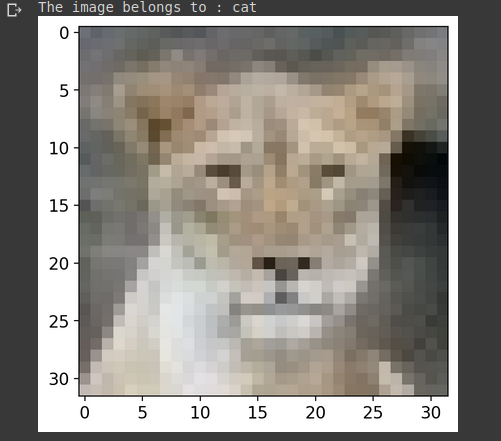

Now lets train the network on the completely shuffled data and see if it memorizes.

100%|██████████| 200/200 [00:38<00:00,  5.17it/s]


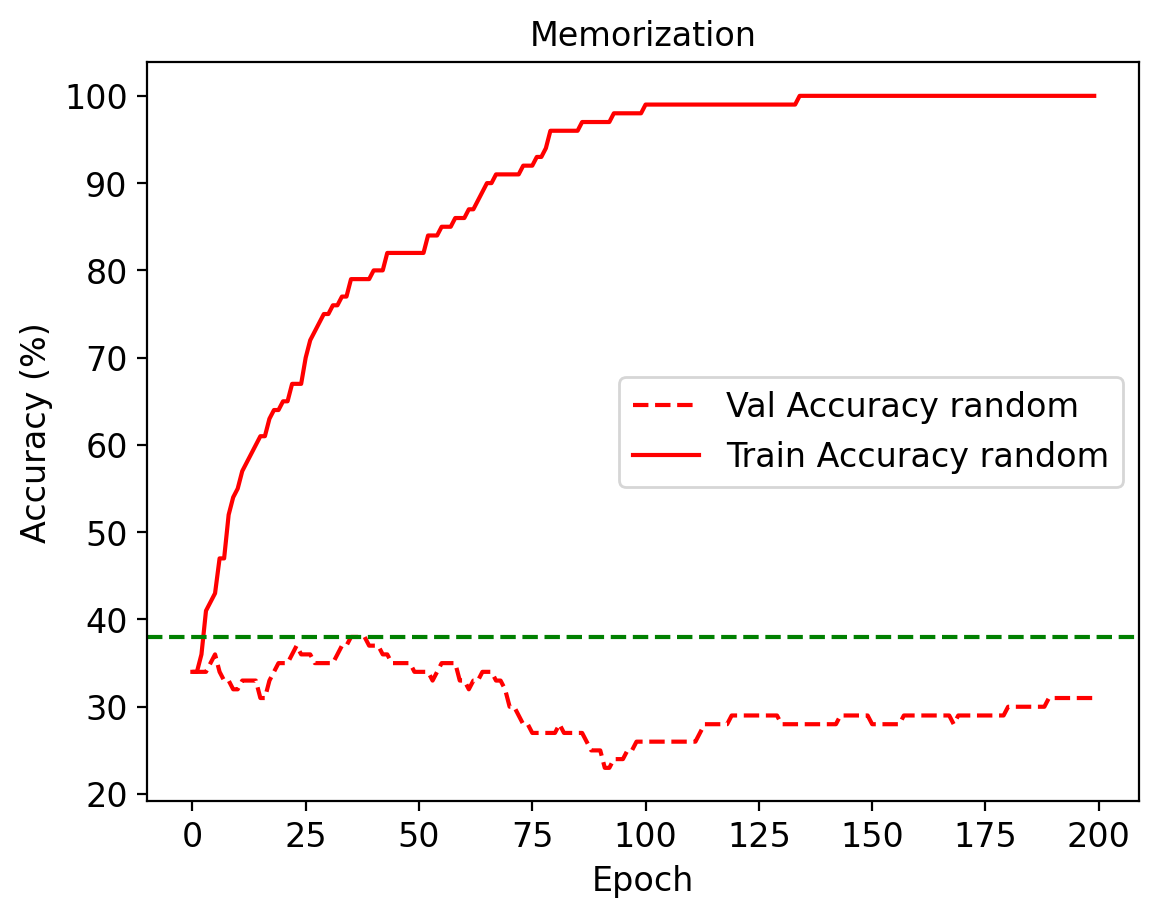

In [ ]:
##Here we have 100 completely shuffled train data.
args = {'epochs': 200,
        'lr': 5e-3,
        'momentum': 0.9,
        'no_cuda': False
        }

acc_dict = {}
model = Big_Animal_Net()


val_acc_random, train_acc_random, _,model,_ = main(args,model,rand_train_loader,val_loader,img_test_dataset)

##Train and Test accuracy plot

plt.plot(val_acc_random,label='Val Accuracy random',c='red',ls = 'dashed')
plt.plot(train_acc_random,label='Train Accuracy random',c='red',ls = 'solid')
plt.axhline(y=max(val_acc_random),c = 'green',ls = 'dashed')
plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Finally lets train on a parially shuffled dataset where 15% of the labels are noisy.

100%|██████████| 200/200 [00:30<00:00,  6.59it/s]


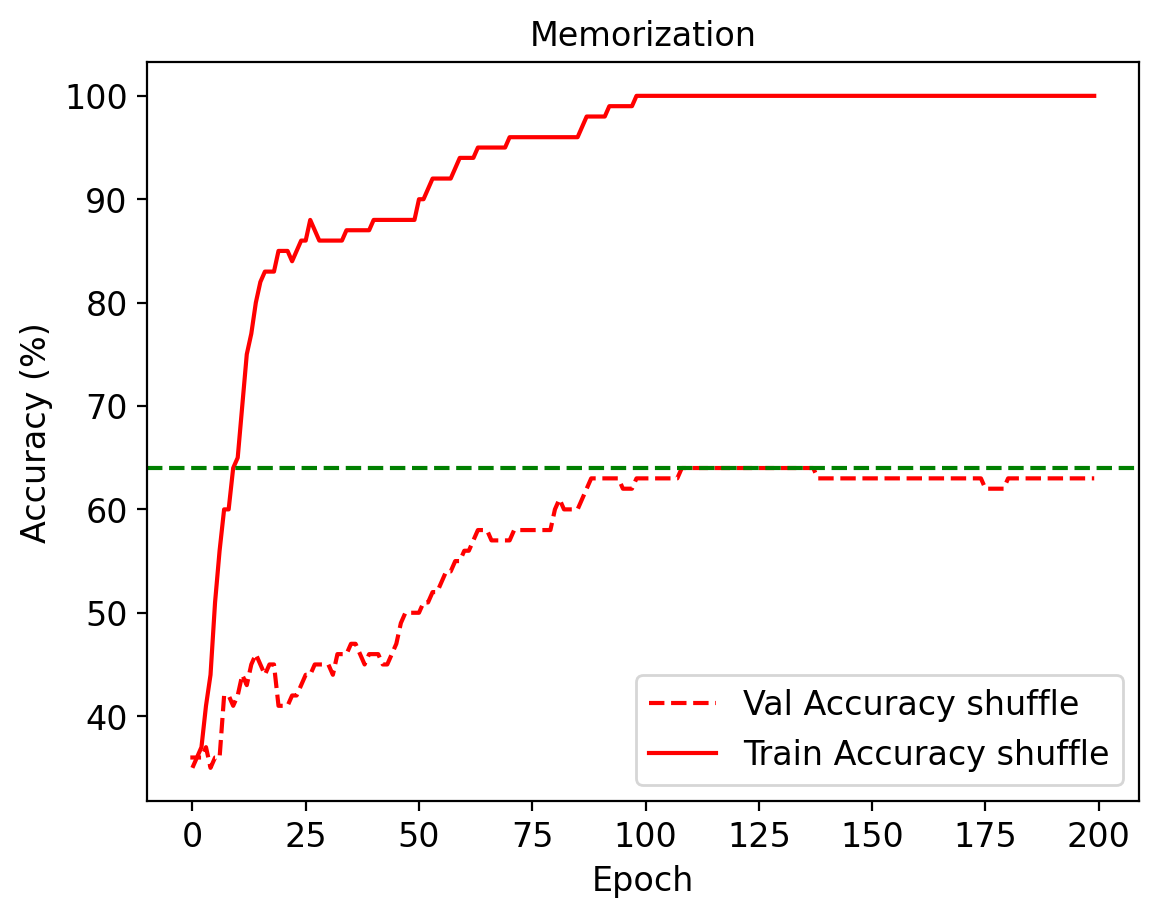

In [ ]:
##Here we have 100 partially shuffled train data.
args = {'test_batch_size': 1000,
        'epochs': 200,
        'lr': 5e-3,
        'momentum': 0.9,
        'no_cuda': False,
        }

acc_dict = {}
model = Big_Animal_Net()


val_acc_shuffle, train_acc_shuffle, _,_,_ = main(args,model,partial_rand_train_loader,val_loader,img_test_dataset)

#train and test acc plot
plt.plot(val_acc_shuffle,label='Val Accuracy shuffle',c='red',ls = 'dashed')
plt.plot(train_acc_shuffle,label='Train Accuracy shuffle',c='red',ls = 'solid')
plt.axhline(y=max(val_acc_shuffle),c = 'green',ls = 'dashed')
plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

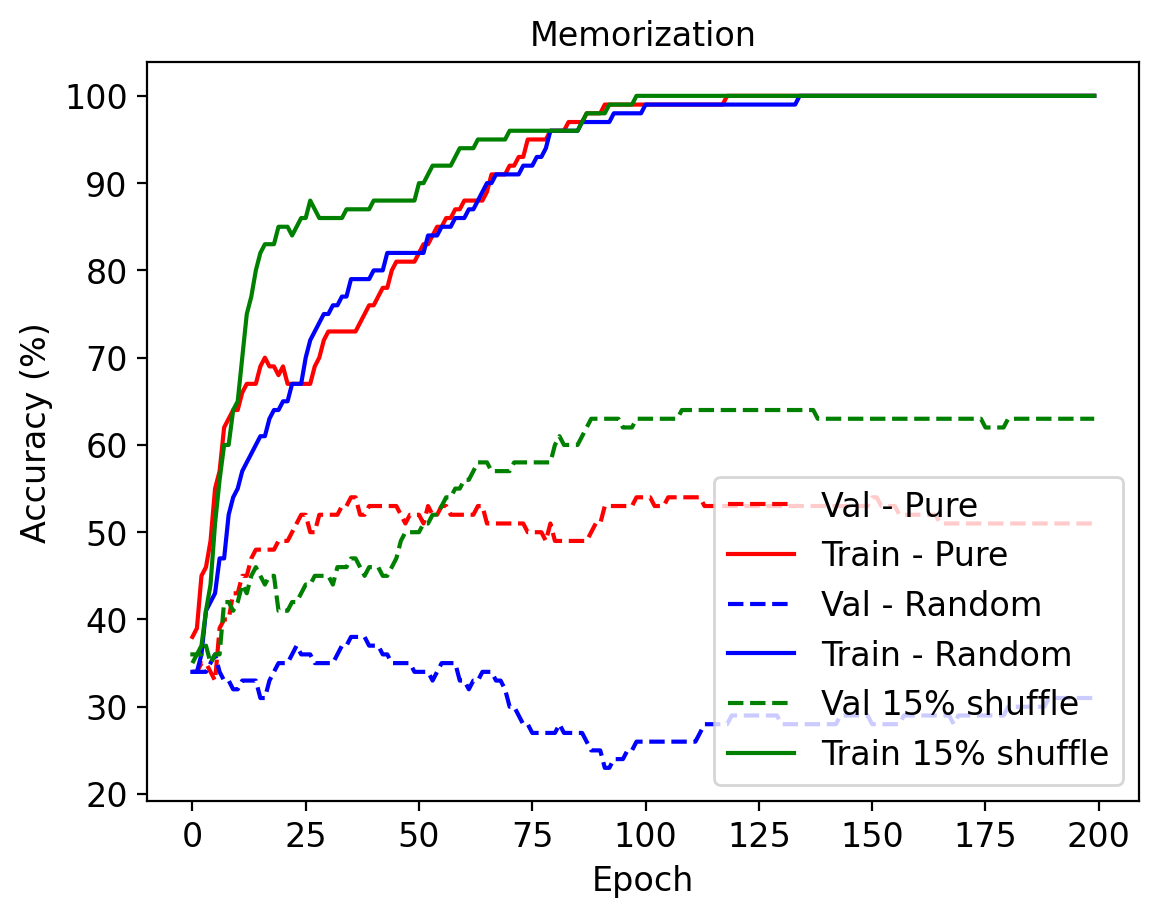

In [ ]:
#Plotting all together
plt.plot(val_acc_pure,label='Val - Pure',c='red',ls = 'dashed')
plt.plot(train_acc_pure,label='Train - Pure',c='red',ls = 'solid')
plt.plot(val_acc_random,label='Val - Random',c='blue',ls = 'dashed')
plt.plot(train_acc_random,label='Train - Random',c='blue',ls = 'solid')
plt.plot(val_acc_shuffle,label='Val 15% shuffle',c='green',ls = 'dashed')
plt.plot(train_acc_shuffle,label='Train 15% shuffle',c='green',ls = 'solid')
plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

**Quiz Question 2:** Given that the NN fit/memorized the training data perfectly, do you think it generalizes well? What makes you think it does or doesn't?


In [ ]:
memorize_or_generalize = '' #@param {type:"string"}

#Section 4: Early Stopping


Video available at https://youtube.com/watch?v=GA6J-50GCWs


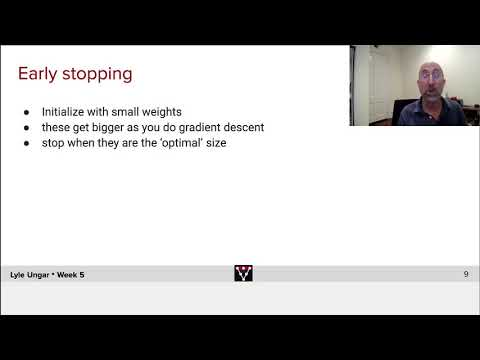

In [ ]:
#@title Video : Early Stopping
try: t4;
except NameError: t4=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="GA6J-50GCWs", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


Now that we have established that the validation accuracy reaches the peak well before the model overfits we want to stop the training early. You should have also observed from the above plots that the train/test loss on real data is not very smooth and hence you might guess that the choice of epoch can play a significant role with respect to the val/test accuracy of your model. 

Early stopping is a way to end training when the validation accuracies do not increase over a certain number of epochs. Though this makes sure that we don't overfit on the train data **it doesn't solve the problem of local variance, i.e. that the accuracy can be very volatile between epochs**. To overcome this, we also save the best model based on the val loss/accuracy for use on test dataset.

![Overfitting](https://images.deepai.org/glossary-terms/early-stopping-machine-learning-5422207.jpg)

## Exercise 3: Early Stopping
Reimplement the main function to include early stopping using the above mentioned stratergy.Then run the code below to validate your implementation.

In [ ]:
def early_stopping_main(args, model,train_loader,val_loader,test_data):

    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Complete the early_stopping_main function")
    ####################################################################

    use_cuda = not args['no_cuda'] and torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')     

    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

    best_acc  = 0.0
    best_epoch = 0

    patience = ...
    wait = ...

    val_acc_list, train_acc_list = [], []

    for epoch in range(1, args['epochs'] + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        train_acc = test(model,device,train_loader, 'Train')
        val_acc = test(model,device,val_loader, 'Val')
        if (val_acc > best_acc):
            #...
            #...
            #...
            #...
        else:
            if (wait > patience):
                #....
                #....
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

    return val_acc_list, train_acc_list, model, best_epoch

In [ ]:
## to_remove

def early_stopping_main(args,model,train_loader,val_loader,test_data):

    """
        Inputs: 
            Model: Pytorch model
            Loaders: Pytorch Train and Validation loaders
        The function trains the model and terminates the training based on the early stopping criterion.
    """

    use_cuda = not args['no_cuda'] and torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')

    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

    patience = 5
    wait = 0

    best_acc  = 0.0
    best_epoch = 0

    val_acc_list, train_acc_list = [], []
    for epoch in range(1, args['epochs'] + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        train_acc = test(model,device,train_loader, 'Train')
        val_acc = test(model,device,val_loader, 'Val')
        if (val_acc > best_acc):
            best_model = copy.deepcopy(model)
            best_acc = val_acc
            best_epoch = epoch
            wait = 1
        else:
            if (wait > patience):
                print('early stopped on epoch:',epoch)
                break
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

    return val_acc_list, train_acc_list, model, best_epoch

In [ ]:
args = {'epochs': 200,
        'lr': 5e-4,
        'momentum': 0.99,
        'no_cuda': False,
        }

acc_dict = {}
model = Animal_Net()

val_acc_pure, train_acc_pure,_,_ ,best_epoch = main(args,model,train_loader,val_loader,img_test_dataset)

model = Animal_Net()
val_acc_earlystop, train_acc_earlystop,_,best_epoch = early_stopping_main(args,model,train_loader,val_loader,img_test_dataset)

print("Maximum Validation Accuracy is reached at epoch:%2d"%(best_epoch))

100%|██████████| 200/200 [00:37<00:00,  5.29it/s]


Maximum Validation Accuracy is reached at epoch:136


**Quiz Question 3:** Do you think Early stopping can be harmful for the training of your network?

In [ ]:
early_stopping = '' #@param {type:"string"}

#Section 5: L1 and L2 Regularization


In [ ]:
#@title Video : L1 and L2 regression
try: t5;
except NameError: t5=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="OLl2nzOeQ68", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Some of you might have already come across L1 and L2 regularization before in other courses. L1 and L2 are the most common types of regularization. These update the general cost function by adding another term known as the regularization term.

***Cost function = Loss (say, binary cross entropy) + Regularization term***

Due to the addition of this regularization term, the values of parameters decrease because it assumes that a neural network with a lower parameter values leads to simpler models. Therefore, it will also reduce overfitting to quite an extent.

##Unregularized Model

In [ ]:
#@title Dataloaders for Regularization
data_path = pathlib.Path('.')/'afhq' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)

#Splitting dataset
reg_train_data, reg_val_data,_ = torch.utils.data.random_split(img_dataset, [30,100,14500])

#Creating train_loader and Val_loader
reg_train_loader = torch.utils.data.DataLoader(reg_train_data,batch_size=batch_size,worker_init_fn=seed_worker)
reg_val_loader = torch.utils.data.DataLoader(reg_val_data,batch_size=1000,worker_init_fn=seed_worker)


100%|██████████| 150/150 [00:12<00:00, 11.80it/s]


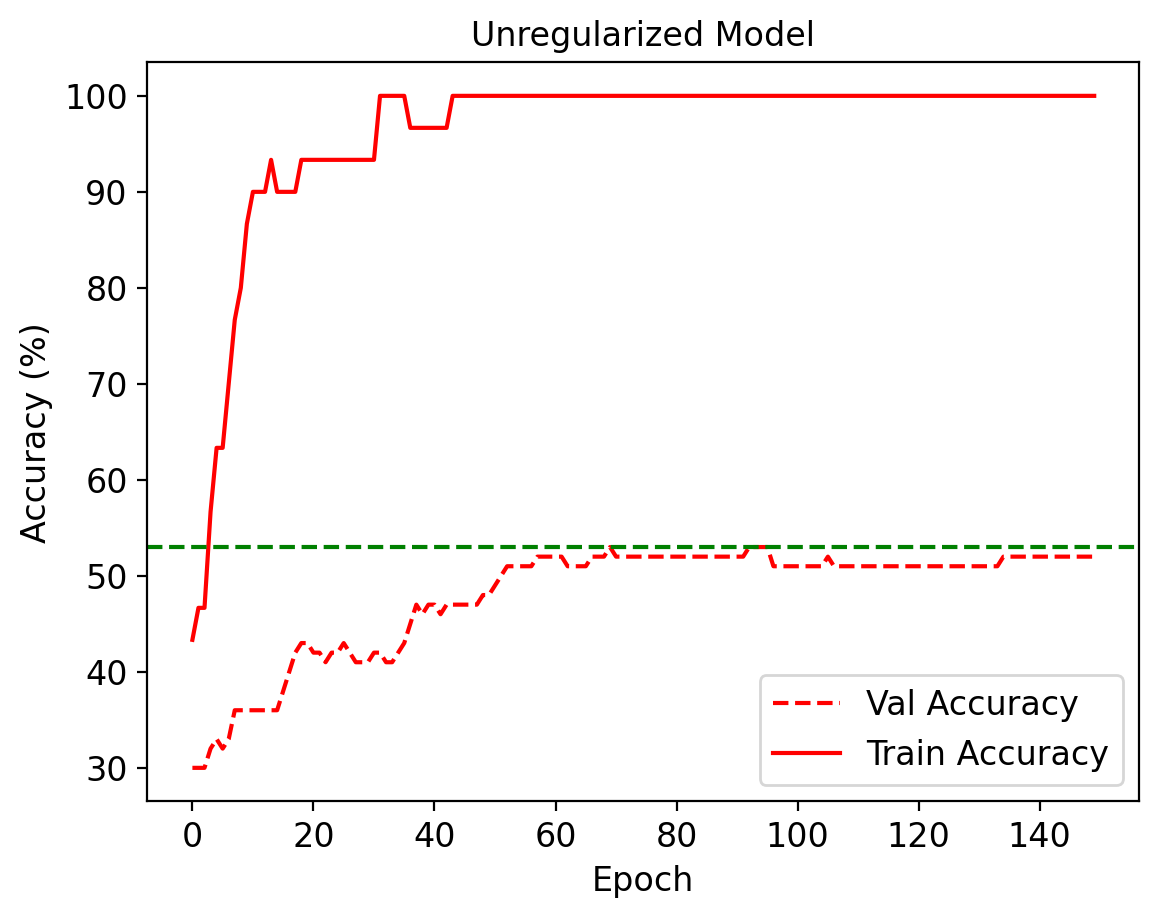

maximum Validation Accuracy reached:53.000000


In [ ]:
args = {'epochs': 150,
        'lr': 5e-3,
        'momentum': 0.99,
        'no_cuda': False,
        }

acc_dict = {}
model = Animal_Net()

val_acc_unreg, train_acc_unreg,param_norm_unreg,_ ,_ = main(args,model,reg_train_loader,reg_val_loader,img_test_dataset)

##Train and Test accuracy plot

plt.plot(val_acc_unreg,label='Val Accuracy',c='red',ls = 'dashed')
plt.plot(train_acc_unreg,label='Train Accuracy',c='red',ls = 'solid')
plt.axhline(y=max(val_acc_unreg),c = 'green',ls = 'dashed')
plt.title('Unregularized Model')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print('maximum Validation Accuracy reached:%f'%max(val_acc_unreg))

##L1/LASSO Regularization

L1 Regularization uses a regularization function which is the sum of the absolute value of all the weights in DLN, resulting in the following loss function ( L  is the usual Cross Entropy loss):

\begin{equation}
L_R=L+λ∑|w^{(r)}_{ij}|
\end{equation}

At a high level L1 Regularization is similar to L2 Regularization since it leads to smaller weights (you will see the analogy in the next subsection). It results in the following weight update equation when using Stochastic Gradient Descent (where  sgn  is the sign function, such that  sgn(w)=+1  if  w>0 ,  sgn(w)=−1  if  $w<0$ , and sgn(0)=0 ):

\begin{equation}
w^{(r)}_{ij}←w^{(r)}_{ij}−ηλsgn(w^{(r)}_{ij})−η\frac{\partial L}{\partial w_{ij}^{r}} 
\end{equation}

###Exerice 4: L1_reg

Write a function which calculates the L1 norm of all the tensors of a Pytorch model.

In [ ]:
def l1_reg(model):

    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Complete the l1_reg function")
    ####################################################################
    l1 = 0
    
    ...
    ...

    return l1

##uncomment to test
# net = nn.Linear(20,20)
# print(f'L1 norm of the model: {l1_reg(net)}')

In [ ]:
## to_remove

def l1_reg(model):
  """
    Inputs: Pytorch model 
    This function calculates the l1 norm of the all the tensors in the model
  """
  l1 = 0

  for param in model.parameters():
    l1 += torch.sum(torch.abs(param))
  
  return l1

net = nn.Linear(20,20)
print(f'L1 norm of the model: {l1_reg(net)}')

L1 norm of the model: 44.51029968261719


[CHANGE: PUT RANGE OF VALUES FOR LAMBDA]
Now, let's train a classifier which uses l1 regularization. Tune the hyperparameter lambda such that the val accuracy is higher than for unregularized model.

100%|██████████| 150/150 [00:15<00:00,  9.65it/s]


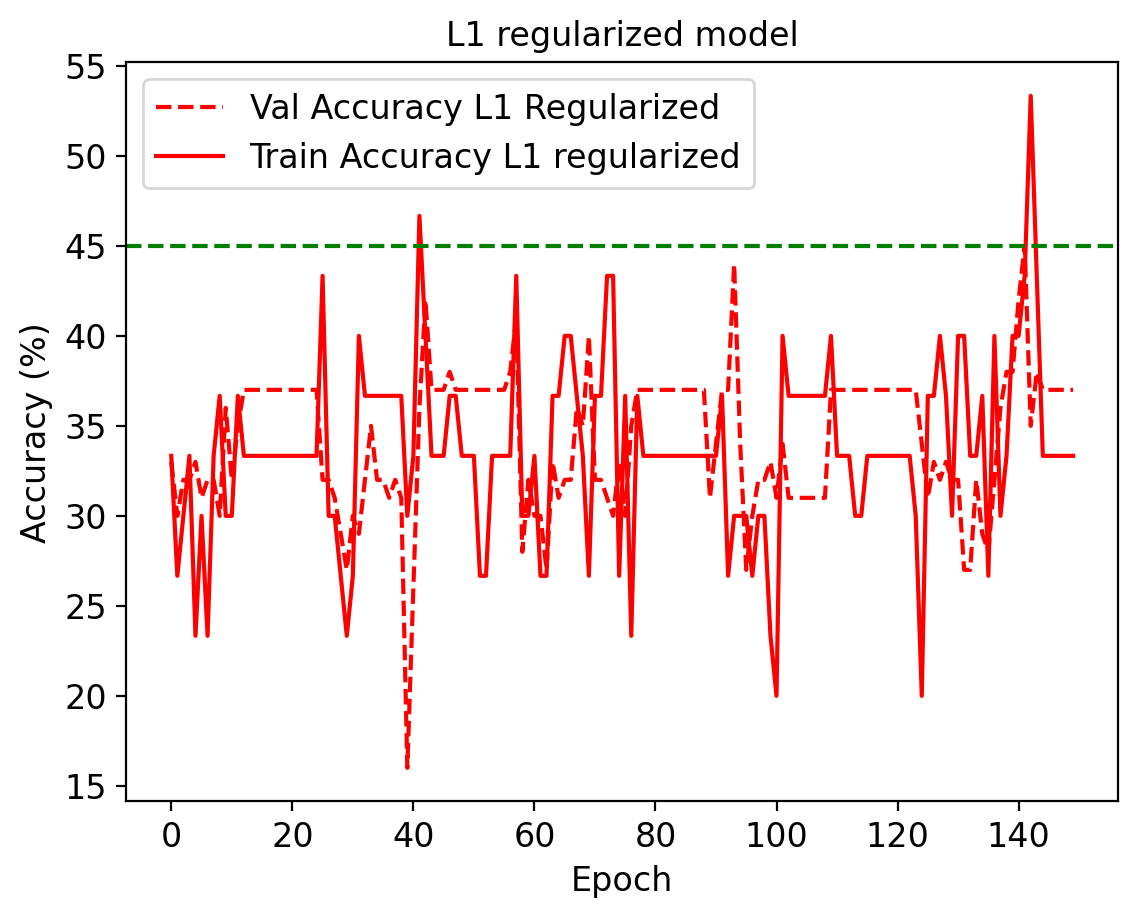

maximum Validation Accuracy reached:45.000000


In [ ]:
args = {'epochs': 150,
        'lr': 5e-3,
        'momentum': 0.99,
        'no_cuda': False,
        'lambda': 0.8
        }

acc_dict = {}
model = Animal_Net()

val_acc_l1reg, train_acc_l1reg,param_norm_l1reg,_,_ = main(args,model,reg_train_loader,reg_val_loader,img_test_dataset,reg_function1=l1_reg)

##Train and Test accuracy plot

plt.plot(val_acc_l1reg,label='Val Accuracy L1 Regularized',c='red',ls = 'dashed')
plt.plot(train_acc_l1reg,label='Train Accuracy L1 regularized',c='red',ls = 'solid')
plt.axhline(y=max(val_acc_l1reg),c = 'green',ls = 'dashed')
plt.title('L1 regularized model')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print('maximum Validation Accuracy reached:%f'%max(val_acc_l1reg))

**Quiz Question 4:** What value of Lambda worked for L1 Regularization?

In [ ]:
lambda_1 = '' #@param {type:"string"}

##L2 / Ridge Regularization

L2 Regularization is a commonly used technique in ML systems is also sometimes referred to as “Weight Decay”. It works by adding a quadratic term to the Cross Entropy Loss Function  L , called the Regularization Term, which results in a new Loss Function  LR  given by:

\begin{equation}
LR=L+λ∑(w^{(r)}_{ij})^2
\end{equation}

In order to get further insight into L2 Regularization, we investigate its effect on the Gradient Descent based update equations for the weight and bias parameters. Taking the derivative on both sides of the above equation, we obtain

\begin{equation}
\frac{\partial L_r}{\partial w^{(r)}_{ij}}=\frac{\partial L}{\partial w^{(r)}_{ij}}+λw^{(r)}_{ij}
\end{equation}
Thus the weight update rule becomes:

\begin{equation}
w^{(r)}_{ij}←w^{(r)}_{ij}−η\frac{\partial L}{\partial W^{(r)}_{ij}}−ηλw^{(r)}_{ij}=(1−ηλ)w^{(r)}_{ij}−η\frac{\partial L}{\partial w^{(r)}_{ij}}
\end{equation}

where, $\eta$ is learning rate.

###Exerice 5: L2_reg

Write a function which calculates the L1 norm of all the tensors of a Pytorch model.

In [ ]:
def l2_reg(model):

    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Complete the l2_reg function")
    ####################################################################
    l2 = 0

    ...
    ...

    return l2

##uncomment to test
# net = nn.Linear(20,20)
# print(f'L2 norm of the model: {l2_reg(net)}')

In [ ]:
def l2_reg(model):

  """
    Inputs: Pytorch model 
    This function calculates the l2 norm of the all the tensors in the model
  """

  l2 = 0.0

  for param in model.parameters():
    l2 += torch.sum(torch.abs(param)**2)
  
  return l2

net = nn.Linear(20,20)
print(f'L2 norm of the model: {l2_reg(net)}')

L2 norm of the model: 6.491175174713135


[CHANGE: PUT RANGE OF VALUES FOR LAMBDA]
Now, let's train a classifier which uses l2 regularization. Tune the hyperparameter lambda1 such that the val accuracy is higher than for unregularized model.

In [ ]:
args = {'test_batch_size': 1000,
        'epochs': 150,
        'lr': 5e-3,
        'momentum': 0.99,
        'no_cuda': False,
        'lambda': 
        }

acc_dict = {}
model = Animal_Net()

val_acc_l2reg, train_acc_l2reg,param_norm_l2reg,model ,_ = main(args,model,train_loader,val_loader,img_test_dataset,reg_function1=l2_reg)

##Train and Test accuracy plot

plt.plot(val_acc_l2reg,label='Val Accuracy L2 regularized',c='red',ls = 'dashed')
plt.plot(train_acc_l2reg,label='Train Accuracy L2 regularized',c='red',ls = 'solid')
plt.axhline(y=max(val_acc_l2reg),c = 'green',ls = 'dashed')
plt.title('L2 Regularized Model')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print('maximum Validation Accuracy reached:%f'%max(val_acc_l2reg))

**Quiz Question 5:** What value of Lambda worked for L2 Regularization?

In [ ]:
lambda_2 = '' #@param {type:"string"}

##L1+L2 / Elastic net regularization
[CHANGE: PUT RANGE OF VALUES FOR LAMBDA]
Elastic Net regularization uses both L1 and L2 weights for regression. The loss function becomes:

\begin{equation}
LR=L+ λ_{1}∑|w^{(r)}_{ij}| + λ_{2}∑(w^{(r)}_{ij})^2
\end{equation}

The weights update equation then becomes:

\begin{equation}
w^{(r)}_{ij}←(1−ηλ_{2})w^{(r)}_{ij}−ηλ_{1}sgn(w^{(r)}_{ij})−η\frac{\partial L}{\partial w_{ij}^{r}} 
\end{equation}

where, $\eta$ is learning rate.

Now, let's train a classifier which uses both l1 and l2 regularization. Tune the hyperparameters lambda1 and lambda2 such that the val accuracy is higher or on par with other models.

In [ ]:
args = {'epochs': 150,
        'lr': 5e-3,
        'momentum': 0.99,
        'no_cuda': False,
        'lambda1': 0.2,
        'lambda2': 0.8
        }

acc_dict = {}
model = Animal_Net()

val_acc_l1l2reg, train_acc_l1l2reg,param_norm_l1l2reg,model ,_ = main(args,model,train_loader,val_loader,img_test_dataset,reg_function1=l1_reg,reg_function2=l2_reg)

##Train and Test accuracy plot

plt.plot(val_acc_l1l2reg,label='Val L1+L2',c='red',ls = 'dashed')
plt.plot(train_acc_l1l2reg,label='Train L1+L2',c='red',ls = 'solid')
plt.axhline(y=max(val_acc_l1l2reg),c = 'green',ls = 'dashed')
plt.title('L1+L2 Regularized Model')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print('maximum Validation Accuracy reached:%f'%max(val_acc_l1l2reg))

**Quiz Question 6:** What values of Lambda worked for Elastic Net Regularization?

In [ ]:
elastic_net = '' #@param {type:"string"}

In [ ]:
plt.plot(val_acc_l2reg,c='red',ls = 'dashed')
plt.plot(train_acc_l2reg,label='L2 regularized',c='red',ls = 'solid')
plt.axhline(y=max(val_acc_l2reg),c = 'red',ls = 'dashed')
plt.plot(val_acc_l1reg,c='green',ls = 'dashed')
plt.plot(train_acc_l1reg,label='L1 regularized',c='green',ls = 'solid')
plt.axhline(y=max(val_acc_l1reg),c = 'green',ls = 'dashed')
plt.plot(val_acc_unreg,c='blue',ls = 'dashed')
plt.plot(train_acc_unreg,label='Unregularized',c='blue',ls = 'solid')
plt.axhline(y=max(val_acc_unreg),c = 'blue',ls = 'dashed')
plt.plot(val_acc_l1l2reg,c='orange',ls = 'dashed')
plt.plot(train_acc_l1l2reg,label='L1+L2 regularized',c='orange',ls = 'solid')
plt.axhline(y=max(val_acc_l1l2reg),c = 'orange',ls = 'dashed')

plt.title('Unregularized Vs L1-Regularized vs L2-regularized Vs L1+L2 regularized')
plt.xlabel('epoch')
plt.ylabel('Accuracy(%)')
plt.legend()
plt.show()

NameError: ignored

Now, let's visualize what these different regularization does to the parameters of the model. We observe the effect by doing a frobenius norm of the model parameters

In [ ]:
plt.plot(param_norm_unreg,label='Unregularized',c = 'blue')
plt.plot(param_norm_l1reg,label = 'L1 Regularized', c='green')
plt.plot(param_norm_l2reg,label='L2 Regularized',c='red')
plt.plot(param_norm_l1l2reg,label='L1+L2 Regularized',c='orange')
plt.title('Parameter Norm as a function of training Epoch')
plt.xlabel('epoch')
plt.ylabel('Parameter Norms')
plt.legend()
plt.show()

In the above plots, you should have seen that even after the model achieves 100% train accuracy the val accuraices are fluctuating, this would indicate that the model is still trying to learn something. 

**Quiz Question 7:** Why whould this be the case?

In [ ]:
variation = '' #@param {type:"string"}

#Section 6: Dropout


In [ ]:
#@title Video : Dropout
try: t6;
except NameError: t6=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="a4nX4T-3xsc", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


Dropout involves injecting noise while computing each internal layer during forward propagation. The method is called dropout because we literally drop out some neurons during training. Throughout training, on each iteration, standard dropout consists of zeroing out some fraction of the nodes in each layer before calculating the subsequent layer.

![Dropout](https://d2l.ai/_images/dropout2.svg)


Now lets revisit the toy dataset that we generated above to visualize how the dropout stabilizes training on a noisy dataset

In [ ]:
##Network Class - 2D
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(1, 300)
        self.fc2 = nn.Linear(300, 500)
        self.fc3 = nn.Linear(500, 1)
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        x = F.leaky_relu(self.dropout1(self.fc1(x)))
        x = F.leaky_relu(self.dropout2(self.fc2(x)))
        output = self.fc3(x)
        return output

In [ ]:
#train the network on toy dataset
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr = 1e-4)
max_epochs = 10000
iters = 0

running_predictions_dp = np.empty((40,(int)(max_epochs/500)))

train_loss_dp = []
test_loss_dp = []
model_norm_dp = []

for epoch in tqdm(range(max_epochs)):

    #training
    model_norm_dp.append(calculate_frobenius_norm(model))
    model.train()
    optimizer.zero_grad()
    predictions = model(X)
    loss = criterion(predictions,Y)
    loss.backward()
    optimizer.step()

    train_loss_dp.append(loss.data)
    model.eval()
    Y_test = model(X_test)
    loss = criterion(Y_test,2*X_test)
    test_loss_dp.append(loss.data)

    if(epoch % 500 == 0 or epoch == max_epochs):
        running_predictions_dp[:,iters] = Y_test[:,0,0].detach().numpy()
        iters += 1

Now that we have finished training, let's see how the model has evolved over the training process.

In [ ]:
fig = plt.figure()
ax = plt.axes()
def frame(i):
    ax.clear()
    ax.scatter(X[:,0,:].numpy(),Y[:,0,:].numpy())
    plot = ax.plot(X_test[:,0,:].detach().numpy(),running_predictions_dp[:,i])
    title = "Epoch: " + str(i * 500)
    plt.title(title)
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    return plot
anim = animation.FuncAnimation(fig, frame, frames=range(20), blit=False, repeat=False, repeat_delay=10000)
anim

In [ ]:
#@title Plot the train and test losses [You may have to run this twice]
plt.plot(test_loss_dp,label='test_loss dropout',c = 'blue',ls='dashed')
plt.plot(test_loss,label='test_loss',c = 'red',ls='dashed')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('loss vs epoch')
plt.legend()
plt.show()

In [ ]:
#@title Plot model weights with epoch
plt.plot(model_norm_dp,label = 'dropout')
plt.plot(model_norm,label = 'no dropout')
plt.ylabel('norm of the model')
plt.xlabel('epochs')
plt.legend()
plt.title('Size of the model vs Epochs')
plt.show()

##Dropout Implementation Caveats: 


*  Dropout is used only during training the model, during testing the complete model weights are used and hence it is important to use model.eval() before testing the model. 

* Dropout reduces the capacity of the model during training and hence as a general practice wider networks are used when using dropout. If you are using a dropout with a random probability of 0.5 then you might want to double the number of hidden neurons in that layer.

Now, lets see how Dropout fares on the Animal Faces Dataset. We first modify the existing model to include dropouts and then train the model.

In [ ]:
##Network Class - Animal Faces
class Animal_Net_Dropout(nn.Module):
    def __init__(self):
        torch.manual_seed(32)
        super(Animal_Net_Dropout, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 248)
        self.fc2 = nn.Linear(248, 210)
        self.fc3 = nn.Linear(210, 3)
        self.dropout1 = nn.Dropout(p = 0.5)
        self.dropout2 = nn.Dropout(p = 0.3)

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.leaky_relu(self.dropout1(self.fc1(x)))
        x =F.leaky_relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
args = {'test_batch_size': 1000,
        'epochs': 200,
        'lr': 5e-3,
        'batch_size': 32,
        'momentum': 0.9,
        'no_cuda': False,
        'seed': 1,
        'log_interval': 100
        }

acc_dict = {}
model = Animal_Net_Dropout()

val_acc_dropout, train_acc_dropout, _, model ,_ = main(args,model,train_loader,val_loader,img_test_dataset)

##Train and Test accuracy plot

plt.plot(val_acc_pure,label='Val',c='blue',ls = 'dashed')
plt.plot(train_acc_pure,label='Train',c='blue',ls = 'solid')
plt.plot(val_acc_dropout,label='Val - DP',c='red',ls = 'dashed')
plt.plot(train_acc_dropout,label='Train - DP',c='red',ls = 'solid')
plt.title('Dropout')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#Section 7: Data Augmentation


In [ ]:
#@title Video : Data Augmentation
try: t6;
except NameError: t6=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="NvwRMX6v-S8", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

While training alpha-zero you were introduced to data augmentation. There data augmentation was used as a tool to increase the number of training samples. Now we will explore the effects of Data Augmentation on regularization. Here regularization is acheived by adding noise into training data after every epoch.

Pytorch's torchvision module provides a few inbuilt data augmentation techniques which we can use on image datasets. Some of the techniques we most frequently use are:


*   Random Crop
*   Random Rotate
*   Vertical Flip
*   Horizontal Flip



In [ ]:
#@title Data Loader without Data Augmentation
train_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    
     ])
data_path = pathlib.Path('.')/'afhq' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)

#Splitting dataset
img_train_data, img_val_data,_ = torch.utils.data.random_split(img_dataset, [250,100,14280])

#Creating train_loader and Val_loader
train_loader = torch.utils.data.DataLoader(img_train_data,batch_size=batch_size,worker_init_fn=seed_worker)
val_loader = torch.utils.data.DataLoader(img_val_data,batch_size=1000,worker_init_fn=seed_worker)

In [ ]:
##Data Augmentation using transforms
new_transforms = transforms.Compose([
                                     transforms.RandomHorizontalFlip(p=0.1),
                                     transforms.RandomVerticalFlip(p=0.1),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

data_path = pathlib.Path('.')/'afhq' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=new_transforms)
#Splitting dataset
new_train_data, _,_ = torch.utils.data.random_split(img_dataset, [250,100,14280])

#Creating train_loader and Val_loader
new_train_loader = torch.utils.data.DataLoader(new_train_data,batch_size=batch_size,worker_init_fn=seed_worker)

In [ ]:
args = {'epochs': 250,
        'lr': 1e-3,
        'momentum': 0.99,
        'no_cuda': False,
        }


acc_dict = {}
model = Animal_Net()

val_acc_dataaug, train_acc_dataaug, param_norm_datadug, _ ,_ = main(args,model,new_train_loader,val_loader,img_test_dataset)
model = Animal_Net()
val_acc_pure, train_acc_pure, param_norm_pure,_,_ = main(args,model,train_loader,val_loader,img_test_dataset)


##Train and Test accuracy plot

plt.plot(val_acc_pure,label='Val Accuracy Pure',c='red',ls = 'dashed')
plt.plot(train_acc_pure,label='Train Accuracy Pure',c='red',ls = 'solid')

plt.plot(val_acc_dataaug,label='Val Accuracy data augment',c='blue',ls = 'dashed')
plt.plot(train_acc_dataaug,label='Train Accuracy data augment',c='blue',ls = 'solid')
plt.axhline(y=max(val_acc_pure),c = 'red',ls = 'dashed')
plt.axhline(y=max(val_acc_dataaug),c = 'blue',ls = 'dashed')
plt.title('Data Augmentation')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
plt.plot(param_norm_pure,c='red',label = 'Without Augmentation')
plt.plot(param_norm_datadug,c='blue',label='With Augmentation')
plt.title('Norm of parameters as a function of training epoch')
plt.xlabel('epoch')
plt.ylabel('Norm of model parameters')
plt.legend()
plt.show()

**Quiz Question 8:** Can you think of more ways of augmenting training data?

In [ ]:
data_augment = '' #@param {type:"string"}

---
# Wrap up

## Submit responses

In [ ]:
#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**

import time
import numpy as np
import urllib.parse
from IPython.display import IFrame

def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  #prefills = "&".join(["prefill_%s=%s"%(key, fields[key]) for key in fields])
  #src = src + prefills
  #src = "+".join(src.split(" "))
  #return src

  prefill_fields = {}
  for key in fields:
      new_key = 'prefill_' + key
      prefill_fields[new_key] = fields[key]
  prefills = urllib.parse.urlencode(prefill_fields)
  src = src + prefills
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()

#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: my_email;
except NameError: my_email = ""

try: trend;
except NameError: trend = ""
try: memorize_or_generalize;
except NameError: memorize_or_generalize = ""
try: early_stopping;
except NameError: early_stopping = ""
try: variation;
except NameError: variation = ""
try: lambda_1;
except NameError: lambda_1 = ""
try: lambda_2;
except NameError: lambda_2 = ""
try: elastic_net;
except NameError: elastic_net = ""
try: data_augment;
except NameError: data_augment = ""

times = [(t-t0) for t in [t1]]

fields = {"pennkey": my_pennkey,
          "my_pod": my_pod,
          "email": my_email,
          "trend": trend,
          "memorize_or_generalize": memorize_or_generalize,
          "early_stopping": early_stopping,
          "variation": variation,
          "lambda_1": lambda_1,
          "lambda_2": lambda_2,
          "elastic_net": elastic_net,
          "data_augment": data_augment,
          "cumulative_times": times
        }

src = "https://airtable.com/embed/shrXrrMFkvePCRHoJ?"

#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))


## Feedback
How could this session have been better? How happy are you in your group? How do you feel right now?

Feel free to use the embeded form below or use this link:
<a target="_blank" rel="noopener noreferrer" href="https://airtable.com/shr1TzujOOOY21kFQ">https://airtable.com/shr1TzujOOOY21kFQ</a>

In [ ]:
# @title Feedback form
display(IFrame(src="https://airtable.com/embed/shr1TzujOOOY21kFQ", width = 800, height = 400))